In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [27]:
rating_complete = pd.read_csv('./2020/rating_complete.csv')

In [28]:
rating_complete

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
...,...,...,...
57633273,353404,502,8
57633274,353404,987,4
57633275,353404,225,8
57633276,353404,243,7


In [29]:
rating_complete.describe()

,user_id,anime_id,rating
count,5.763328e+07,5.763328e+07,5.763328e+07
mean,1.768878e+05,1.583147e+04,7.510789e+00
std,1.020117e+05,1.326114e+04,1.697722e+00
min,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.827800e+04,3.091000e+03,7.000000e+00
50%,1.772910e+05,1.188700e+04,8.000000e+00
75%,2.654190e+05,2.899900e+04,9.000000e+00
max,3.534040e+05,4.845600e+04,1.000000e+01


In [4]:
item = pd.read_csv('./2020/anime.csv')

In [5]:
item.rename(columns={'MAL_ID': 'anime_id'}, inplace=True)

In [31]:
# 각 유저의 rating 개수 계산
user_rating_counts = rating_complete['user_id'].value_counts()

# rating 개수가 11 이상 1000 이하인 유저들 필터링
users_with_11_to_1000_ratings = user_rating_counts[(user_rating_counts >= 11) & (user_rating_counts <= 500)].index

# 해당 유저들의 rating 데이터만 추출
rating = rating_complete[rating_complete['user_id'].isin(users_with_11_to_1000_ratings)]
rating

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
...,...,...,...
57633273,353404,502,8
57633274,353404,987,4
57633275,353404,225,8
57633276,353404,243,7


In [32]:
rating

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
...,...,...,...
57633273,353404,502,8
57633274,353404,987,4
57633275,353404,225,8
57633276,353404,243,7


In [35]:
rating_counts = rating['user_id'].value_counts().value_counts()
rating_counts

count
11     1903
12     1765
15     1706
14     1702
13     1689
       ... 
470      91
494      90
484      90
496      90
495      83
Name: count, Length: 490, dtype: int64

In [13]:
user_positive_dict = (
    rating.groupby('user_id')['anime_id'].apply(set).to_dict()
)

In [14]:
all_item_ids = set(item["anime_id"].unique())

In [15]:
import json
from tqdm import tqdm

# 음성 샘플링 비율
negative_sample_ratio = 4

with open("user_negative_samples.json", "w") as jsonfile:
    data_to_save = {}

    for user, positive_items in tqdm(user_positive_dict.items(), desc="Saving negative samples to file"):
        # 음성 후보군 생성
        negative_candidates = list(all_item_ids - positive_items)
        # 네거티브 샘플링
        num_samples = len(positive_items) * negative_sample_ratio
        sampled_negatives = [int(i) for i in np.random.choice(negative_candidates, size=num_samples, replace=False)]
        # 데이터를 딕셔너리로 저장
        data_to_save[user] = sampled_negatives

    json.dump(data_to_save, jsonfile)

Saving negative samples to file: 100%|██████████| 257607/257607 [06:31<00:00, 658.68it/s]


In [7]:
import json

with open("user_negative_samples.json", "r") as jsonfile:
    negative_samples_dict = json.load(jsonfile)

print(list(negative_samples_dict.items())[:5]) 

[('0', [2717, 2641, 35686, 32879, 39519, 30133, 33242, 31255, 34688, 9645, 38954, 17321, 38254, 25977, 11209, 22791, 3174, 2897, 41663, 911, 42048, 39046, 18319, 16748, 31829, 31783, 30362, 42446, 31700, 40879, 4790, 40351, 33045, 14623, 27775, 1879, 136, 28087, 36582, 5520, 13365, 38353, 7398, 16345, 9900, 4733, 19271, 41913, 4462, 2165, 1434, 42249, 39242, 33036, 17813, 30840, 3219, 40321, 33232, 39925, 38716, 36275, 29381, 38867, 41457, 35311, 41461, 6046, 33945, 359, 1782, 21241, 38010, 6771, 21373, 8311, 33926, 2488, 2664, 12755, 39430, 39480, 5356, 1454, 102, 38319, 3185, 898, 30544, 31344, 37232, 39426, 40283, 48427, 3044, 55, 35880, 1591, 39587, 34531, 3036, 39502, 38251, 38284, 2299, 39517, 37895, 1168, 5762, 37646, 3826, 42890, 2485, 1491, 36498, 38606, 2479, 13299, 6862, 2875, 36323, 5165, 41848, 42506, 34975, 2461, 40105, 20517, 1241, 18451, 1042, 22433, 27967, 31403, 98, 9095, 376, 42745, 7982, 3622]), ('1', [37446, 39256, 39406, 42340, 27909, 13513, 29946, 10706, 23787, 3

In [8]:
positive_data = rating
positive_data['interaction'] = 1

print(positive_data.head())

   user_id  anime_id  rating  interaction
0        0       430       9            1
1        0      1004       5            1
2        0      3010       7            1
3        0       570       7            1
4        0      2762       9            1


C:\Users\baeku\AppData\Local\Temp\ipykernel_10316\663328509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data['interaction'] = 1


In [11]:
train_positive = []
test_positive = []

for user_id, group in tqdm(positive_data.groupby("user_id")):
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_positive.append(train)
    test_positive.append(test)

train_positive = pd.concat(train_positive).reset_index(drop=True)
test_positive = pd.concat(test_positive).reset_index(drop=True)

print(f"Train Positive: {len(train_positive)}")
print(f"Test Positive: {len(test_positive)}")

100%|██████████| 257607/257607 [01:43<00:00, 2485.94it/s]


Train Positive: 30657518
Test Positive: 7794317


In [12]:
from tqdm import tqdm

negative_samples = []

# 네거티브 샘플 데이터 행 단위 변환환
for user_id, items in tqdm(negative_samples_dict.items(), desc="Converting negative samples"):
    for item_id in items:
        negative_samples.append((user_id, item_id, 0))

negative_data = pd.DataFrame(negative_samples, columns=["user_id", "anime_id", "interaction"])

print(negative_data.head())


Converting negative samples: 100%|██████████| 257607/257607 [00:14<00:00, 17738.40it/s]


  user_id  anime_id  interaction
0       0      2717            0
1       0      2641            0
2       0     35686            0
3       0     32879            0
4       0     39519            0


In [13]:
train_negative = []
test_negative = []

for user_id, group in tqdm(negative_data.groupby("user_id")):
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_negative.append(train)
    test_negative.append(test)

train_negative = pd.concat(train_negative).reset_index(drop=True)
test_negative = pd.concat(test_negative).reset_index(drop=True)

print(f"Train Negative: {len(train_negative)}")
print(f"Test Negative: {len(test_negative)}")

100%|██████████| 257607/257607 [02:43<00:00, 1580.00it/s]


Train Negative: 122942662
Test Negative: 30864678


In [14]:
train_data = pd.concat([train_positive, train_negative]).reset_index(drop=True)

test_data = pd.concat([test_positive, test_negative]).reset_index(drop=True)

print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(test_data)}")

Train Data: 153600180
Test Data: 38658995


In [15]:
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [18]:
train_data

,user_id,anime_id,rating,interaction
0,0,2913,6.0,1
1,0,1571,10.0,1
2,0,600,6.0,1
3,0,121,9.0,1
4,0,4086,6.0,1
...,...,...,...,...
153600175,99998,12799,NaN,0
153600176,99998,17621,NaN,0
153600177,99998,34302,NaN,0
153600178,99998,31685,NaN,0


In [26]:
train_data.dtypes

user_id         object
anime_id         int64
rating         float64
interaction      int64
dtype: object

In [2]:
train_data = pd.read_csv("train_data.csv") 
test_data = pd.read_csv("test_data.csv")

print(train_data.head())
print(test_data.head())

   user_id  anime_id  rating  interaction
0        0      2913     6.0            1
1        0      1571    10.0            1
2        0       600     6.0            1
3        0       121     9.0            1
4        0      4086     6.0            1
   user_id  anime_id  rating  interaction
0        0       199     8.0            1
1        0      1689     6.0            1
2        0      2547     7.0            1
3        0      2236    10.0            1
4        0      1829     7.0            1


In [3]:
train_data['user_id'] = train_data['user_id'].astype('int')
test_data['user_id'] = test_data['user_id'].astype('int')

In [4]:
num_users = train_data["user_id"].max() + 1
num_items = train_data["anime_id"].max() + 1

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class MFModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(MFModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        return (user_embeds * item_embeds).sum(dim=1)

# 모델 초기화화
embedding_dim = 50
model = MFModel(num_users, num_items, embedding_dim).to(device)

# 손실 함수와 최적화 설정
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
from torch.utils.data import DataLoader, Dataset

class InteractionDataset(Dataset):
    def __init__(self, data):
        self.user_ids = data["user_id"].values
        self.item_ids = data["anime_id"].values
        self.labels = data["interaction"].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.user_ids[idx], dtype=torch.long),
            torch.tensor(self.item_ids[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float),
        )

train_dataset = InteractionDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

In [8]:
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_ids, item_ids, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(user_ids, item_ids)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/2: 100%|██████████| 150001/150001 [51:28<00:00, 48.57it/s] 


Epoch 1/2, Loss: 97759.1784


Epoch 2/2: 100%|██████████| 150001/150001 [50:47<00:00, 49.22it/s] 

Epoch 2/2, Loss: 25649.0269


In [10]:
save_path = "trained_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to trained_model.pth


#### 추론

In [39]:
user_consumption = (
    train_data[train_data["interaction"] == 1].groupby("user_id")["anime_id"].nunique().reset_index()
)
user_consumption.columns = ["user_id", "num_consumed"]

print(user_consumption.head())

   user_id  num_consumed
0        0            28
1        1            82
2        2            40
3        3           252
4        4            94


In [41]:
sampled_users = (
    user_consumption.groupby("num_consumed").apply(lambda x: x.sample(n=min(20,len(x)), random_state=42)).reset_index(drop=True)
)

target_users = sampled_users["user_id"].unique()
print(f"Number of target users: {len(target_users)}")

Number of target users: 7860


C:\Users\baeku\AppData\Local\Temp\ipykernel_23432\2226267878.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_consumption.groupby("num_consumed").apply(lambda x: x.sample(n=min(20,len(x)), random_state=42)).reset_index(drop=True)


In [42]:
def recommend_top_k_items_sampled(users, model, all_items, train_data, k=10):
    device = next(model.parameters()).device
    recommendations = {}

    for user_id in users:
        # 사용자가 이미 소비한 아이템 제외
        seen_items = train_data[train_data["user_id"] == user_id]["anime_id"].values
        unseen_items = [item for item in all_items if item not in seen_items]

        user_tensor = torch.tensor([user_id] * len(unseen_items), dtype=torch.long).to(device)
        item_tensor = torch.tensor(unseen_items, dtype=torch.long).to(device)

        # 추천 점수 계산
        scores = model(user_tensor, item_tensor).detach().cpu().numpy()

        # Top-K 추천
        top_k_indices = np.argsort(scores)[-k:][::-1]
        recommendations[user_id] = [(unseen_items[i], scores[i]) for i in top_k_indices]

    return recommendations

In [47]:
from tqdm import tqdm
import time

def recommend_top_k_items_sampled(users, model, all_items, train_data, k=10):
    device = next(model.parameters()).device
    recommendations = {}

    start_time = time.time()

    for user_id in tqdm(users, desc="Generating recommendations"):
        seen_items = train_data[train_data["user_id"] == user_id]["anime_id"].values
        unseen_items = [item for item in all_items if item not in seen_items]

        user_tensor = torch.tensor([user_id] * len(unseen_items), dtype=torch.long).to(device)
        item_tensor = torch.tensor(unseen_items, dtype=torch.long).to(device)

        # 추천 점수 계산
        scores = model(user_tensor, item_tensor).detach().cpu().numpy()

        # Top-K 추천
        top_k_indices = np.argsort(scores)[-k:][::-1]
        recommendations[user_id] = [(unseen_items[i], scores[i]) for i in top_k_indices]

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    return recommendations


In [48]:
# 모든 아이템 목록
all_items = train_data["anime_id"].unique()

# 샘플링된 유저들만 추천 생성
recommendations = recommend_top_k_items_sampled(target_users, model, all_items, train_data, k=10)
print(recommendations)

Generating recommendations: 100%|██████████| 7860/7860 [14:18<00:00,  9.16it/s]

Time taken: 858.19 seconds
{np.int64(304726): [(np.int64(4026), np.float32(5.5337305)), (np.int64(4794), np.float32(5.281072)), (np.int64(11069), np.float32(5.032067)), (np.int64(2201), np.float32(4.9417253)), (np.int64(2847), np.float32(4.9388533)), (np.int64(1525), np.float32(4.8948927)), (np.int64(1526), np.float32(4.887036)), (np.int64(1119), np.float32(4.826845)), (np.int64(1120), np.float32(4.8103604)), (np.int64(2842), np.float32(4.790165))], np.int64(21554): [(np.int64(4224), np.float32(3.6779609)), (np.int64(5112), np.float32(3.4242685)), (np.int64(14653), np.float32(3.3814802)), (np.int64(5680), np.float32(3.3083806)), (np.int64(9181), np.float32(3.3020744)), (np.int64(3455), np.float32(3.1990924)), (np.int64(8769), np.float32(3.106465)), (np.int64(33206), np.float32(3.0823655)), (np.int64(1840), np.float32(3.0108871)), (np.int64(6956), np.float32(2.981678))], np.int64(104681): [(np.int64(3092), np.float32(6.4423547)), (np.int64(1042), np.float32(5.8586903)), (np.int64(719), 

In [53]:
import numpy as np

# Precision@K
def precision_at_k(y_true, y_pred, k):
    top_k_pred = y_pred[:k]
    tp = len(set(top_k_pred) & set(y_true))  # True Positives
    return tp / k

# Recall@K
def recall_at_k(y_true, y_pred, k):
    top_k_pred = y_pred[:k]
    tp = len(set(top_k_pred) & set(y_true))  # True Positives
    return tp / len(y_true) if len(y_true) > 0 else 0

# nDCG@K
def ndcg_at_k(y_true, y_pred, k):
    top_k_pred = y_pred[:k]
    dcg = 0
    for i, item in enumerate(top_k_pred):
        if item in y_true:
            dcg += 1 / np.log2(i + 2)  # i+2 because log2 starts at 1 for position 1
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(y_true), k)))
    return dcg / idcg if idcg > 0 else 0

# MAP@K
def map_at_k(y_true, y_pred, k):
    top_k_pred = y_pred[:k]
    score = 0
    num_hits = 0
    for i, item in enumerate(top_k_pred):
        if item in y_true:
            num_hits += 1
            score += num_hits / (i + 1)
    return score / min(len(y_true), k) if len(y_true) > 0 else 0


In [56]:
def evaluate_sampled_recommendations(recommendations, test_data, k=10):
    precision_scores = []
    recall_scores = []
    ndcg_scores = []
    map_scores = []

    start_time = time.time()

    for user_id, preds in tqdm(recommendations.items(), desc="Evaluating recommendations"):
        y_true = test_data[(test_data["user_id"] == user_id) & (test_data["interaction"] == 1)]["anime_id"].values
        y_pred = [item for item, _ in preds]

        precision_scores.append(precision_at_k(y_true, y_pred, k))
        recall_scores.append(recall_at_k(y_true, y_pred, k))
        ndcg_scores.append(ndcg_at_k(y_true, y_pred, k))
        map_scores.append(map_at_k(y_true, y_pred, k))

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Precision@{k}: {np.mean(precision_scores):.4f}")
    print(f"Recall@{k}: {np.mean(recall_scores):.4f}")
    print(f"nDCG@{k}: {np.mean(ndcg_scores):.4f}")
    print(f"MAP@{k}: {np.mean(map_scores):.4f}")
    print(f"Total evaluation time: {elapsed_time:.2f} seconds")



In [68]:
from tqdm import tqdm
import time
import numpy as np

def evaluate_grouped_recommendations(recommendations, test_data, user_consumption, k=10):
    """
    recommendations: dict, 추천 결과
    test_data: DataFrame, 테스트 데이터
    user_consumption: DataFrame, 유저별 소비한 애니메이션 개수
    k: int, Top-K 추천
    """
    # Positive sample만 포함된 테스트 데이터로 필터링
    test_data = test_data[test_data["interaction"] == 1]

    # 유저 소비 개수 기준으로 그룹화
    user_consumption_dict = user_consumption.set_index("user_id")["num_consumed"].to_dict()
    grouped_metrics = {}

    start_time = time.time()

    for user_id, preds in tqdm(recommendations.items(), desc="Evaluating recommendations"):
        # 소비한 애니메이션 개수
        num_consumed = user_consumption_dict[user_id]

        # 실제 상호작용한 아이템
        y_true = test_data[test_data["user_id"] == user_id]["anime_id"].values
        y_pred = [item for item, _ in preds]

        # 그룹별로 지표 초기화
        if num_consumed not in grouped_metrics:
            grouped_metrics[num_consumed] = {
                "precision": [],
                "recall": [],
                "ndcg": [],
                "map": [],
            }

        grouped_metrics[num_consumed]["precision"].append(precision_at_k(y_true, y_pred, k))
        grouped_metrics[num_consumed]["recall"].append(recall_at_k(y_true, y_pred, k))
        grouped_metrics[num_consumed]["ndcg"].append(ndcg_at_k(y_true, y_pred, k))
        grouped_metrics[num_consumed]["map"].append(map_at_k(y_true, y_pred, k))

    # 그룹별 평균 계산
    for num_consumed, metrics in grouped_metrics.items():
        grouped_metrics[num_consumed] = {
            "precision": np.mean(metrics["precision"]),
            "recall": np.mean(metrics["recall"]),
            "ndcg": np.mean(metrics["ndcg"]),
            "map": np.mean(metrics["map"]),
        }

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Total evaluation time: {elapsed_time:.2f} seconds")
    for num_consumed, metrics in sorted(grouped_metrics.items()):
        print(f"\nNumber of consumed items: {num_consumed}")
        print(f"  Precision@{k}: {metrics['precision']:.4f}")
        print(f"  Recall@{k}: {metrics['recall']:.4f}")
        print(f"  nDCG@{k}: {metrics['ndcg']:.4f}")
        print(f"  MAP@{k}: {metrics['map']:.4f}")

    return grouped_metrics

In [72]:
group_metric = evaluate_grouped_recommendations(recommendations, test_data, user_consumption, k=10)

Evaluating recommendations: 100%|██████████| 7860/7860 [00:31<00:00, 247.92it/s]

Total evaluation time: 31.71 seconds

Number of consumed items: 8
  Precision@10: 0.0350
  Recall@10: 0.1167
  nDCG@10: 0.0791
  MAP@10: 0.0450

Number of consumed items: 9
  Precision@10: 0.0100
  Recall@10: 0.0333
  nDCG@10: 0.0158
  MAP@10: 0.0049

Number of consumed items: 10
  Precision@10: 0.0250
  Recall@10: 0.0833
  nDCG@10: 0.0482
  MAP@10: 0.0198

Number of consumed items: 11
  Precision@10: 0.0300
  Recall@10: 0.1000
  nDCG@10: 0.0799
  MAP@10: 0.0489

Number of consumed items: 12
  Precision@10: 0.0500
  Recall@10: 0.1333
  nDCG@10: 0.1330
  MAP@10: 0.0866

Number of consumed items: 13
  Precision@10: 0.0300
  Recall@10: 0.0750
  nDCG@10: 0.0546
  MAP@10: 0.0224

Number of consumed items: 14
  Precision@10: 0.0450
  Recall@10: 0.1125
  nDCG@10: 0.0865
  MAP@10: 0.0439

Number of consumed items: 15
  Precision@10: 0.0300
  Recall@10: 0.0750
  nDCG@10: 0.0717
  MAP@10: 0.0369

Number of consumed items: 16
  Precision@10: 0.0650
  Recall@10: 0.1425
  nDCG@10: 0.1111
  MAP@10: 

In [74]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_grouped_metrics(grouped_metrics, k=10):
    """
    그룹별 평가 지표를 시각화합니다.
    
    Parameters:
    grouped_metrics: dict, 소비한 애니메이션 개수별 평가 지표
    k: int, Top-K 추천
    """
    data = []
    for num_consumed, metrics in grouped_metrics.items():
        data.append({
            "num_consumed": num_consumed,
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "ndcg": metrics["ndcg"],
            "map": metrics["map"],
        })

    metrics_df = pd.DataFrame(data)

    plt.figure(figsize=(12, 8))
    plt.plot(metrics_df["num_consumed"], metrics_df["precision"], marker="o", label=f"Precision@{k}")
    plt.plot(metrics_df["num_consumed"], metrics_df["recall"], marker="s", label=f"Recall@{k}")
    plt.plot(metrics_df["num_consumed"], metrics_df["ndcg"], marker="^", label=f"nDCG@{k}")
    plt.plot(metrics_df["num_consumed"], metrics_df["map"], marker="x", label=f"MAP@{k}")

    plt.title(f"Evaluation Metrics by Number of Consumed Items (Top-{k})", fontsize=16)
    plt.xlabel("Number of Consumed Items", fontsize=14)
    plt.ylabel("Metric Value", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

In [76]:
from scipy.ndimage import gaussian_filter1d

def plot_grouped_metrics_smoothed(grouped_metrics, k=10):
    data = []
    for num_consumed, metrics in grouped_metrics.items():
        data.append({
            "num_consumed": num_consumed,
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "ndcg": metrics["ndcg"],
            "map": metrics["map"],
        })

    metrics_df = pd.DataFrame(data)
    metrics_df.sort_values(by="num_consumed", inplace=True)

    # 라인 스무딩 적용
    smoothed_precision = gaussian_filter1d(metrics_df["precision"], sigma=2)
    smoothed_recall = gaussian_filter1d(metrics_df["recall"], sigma=2)
    smoothed_ndcg = gaussian_filter1d(metrics_df["ndcg"], sigma=2)
    smoothed_map = gaussian_filter1d(metrics_df["map"], sigma=2)

    plt.figure(figsize=(12, 8))
    plt.plot(metrics_df["num_consumed"], smoothed_precision, label=f"Precision@{k}", linewidth=2, color="blue", marker="o", markersize=4)
    plt.plot(metrics_df["num_consumed"], smoothed_recall, label=f"Recall@{k}", linewidth=2, color="orange", marker="s", markersize=4)
    plt.plot(metrics_df["num_consumed"], smoothed_ndcg, label=f"nDCG@{k}", linewidth=2, color="green", marker="^", markersize=4)
    plt.plot(metrics_df["num_consumed"], smoothed_map, label=f"MAP@{k}", linewidth=2, color="red", marker="x", markersize=4)

    plt.title(f"Evaluation Metrics by Number of Consumed Items (Top-{k})", fontsize=16)
    plt.xlabel("Number of Consumed Items", fontsize=14)
    plt.ylabel("Metric Value", fontsize=14)
    plt.legend(fontsize=12, loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

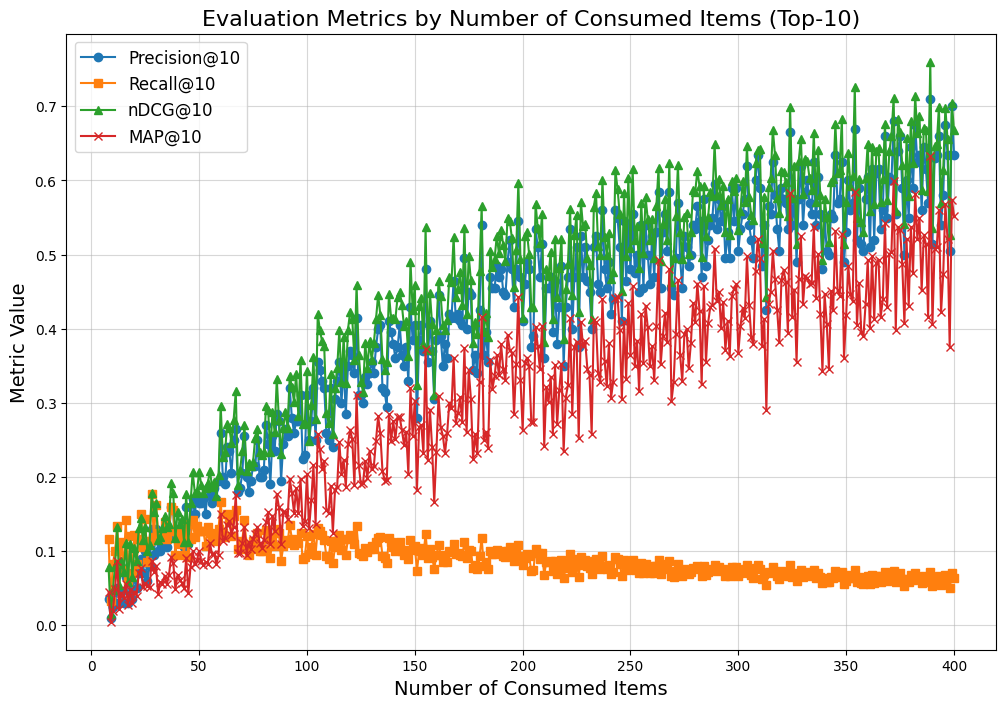

In [75]:
# 그래프 그리기
plot_grouped_metrics(group_metric, k=10)

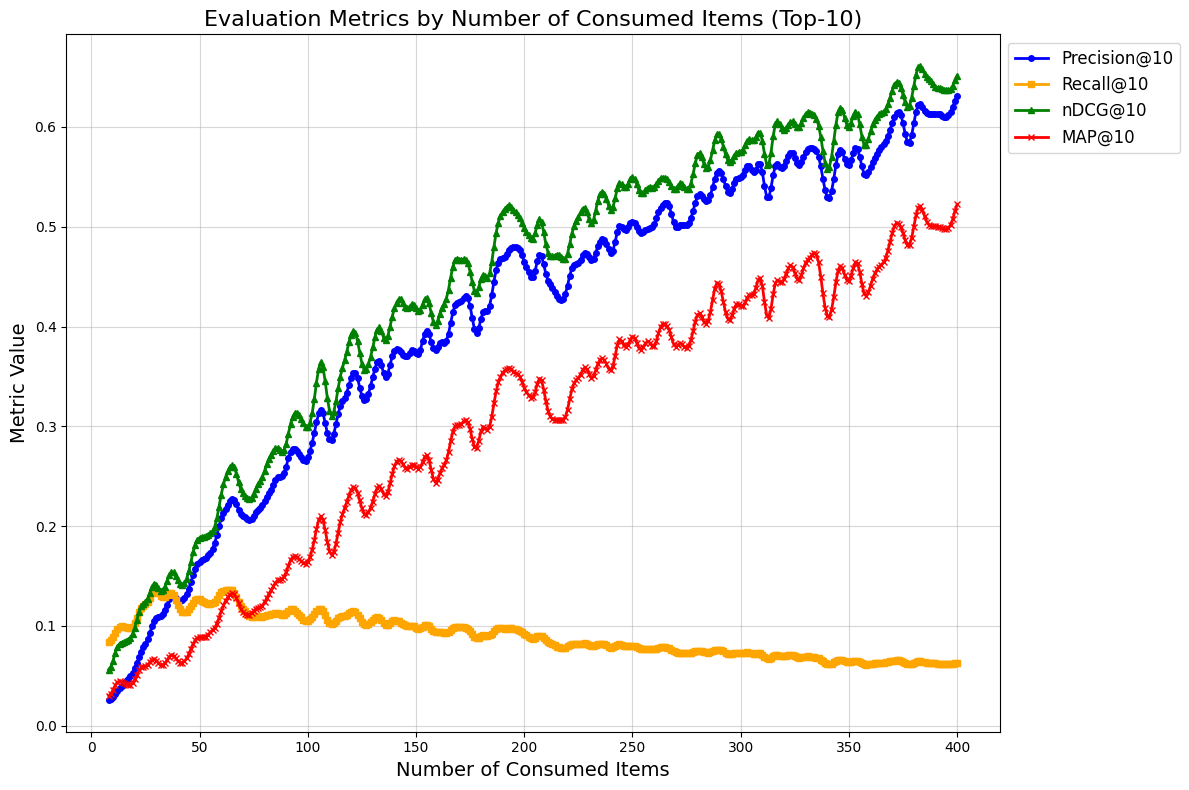

In [77]:
plot_grouped_metrics_smoothed(group_metric, k=10)

In [63]:
# 평가 실행
evaluate_sampled_recommendations(recommendations, test_data, k=10)

Precision@10: 0.4085
Recall@10: 0.0901
nDCG@10: 0.4430
MAP@10: 0.3027


In [64]:
def save_recommendations_to_csv(recommendations, output_file):
    data = []
    for user_id, items in recommendations.items():
        for item_id, score in items:
            data.append({"user_id": user_id, "item_id": item_id, "score": score})

    recommendations_df = pd.DataFrame(data)

    recommendations_df.to_csv(output_file, index=False)
    print(f"Recommendations saved to {output_file}")

In [65]:
# 저장 실행
output_file = "recommendations.csv"
save_recommendations_to_csv(recommendations, output_file)


Recommendations saved to recommendations.csv


In [66]:
data = pd.read_csv('recommendations.csv')

In [67]:
data

,user_id,item_id,score
0,304726,4026,5.533730
1,304726,4794,5.281072
2,304726,11069,5.032067
3,304726,2201,4.941725
4,304726,2847,4.938853
...,...,...,...
78595,102643,5651,4.061745
78596,102643,34759,4.002454
78597,102643,33979,3.926778
78598,102643,28311,3.788051
